In [57]:
import numpy as np
import pandas as pd
#import pandas_datareader.data as web
import yfinance as yf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9,6)
import scipy.optimize as scpopt
import scipy.interpolate as sci
import seaborn as sns
plt.style.use('fivethirtyeight')


In [58]:
### define a taxa livre de risco
selic=10.65
taxa_livre_risco_ad=(1+selic/100) ** (1/252) - 1
### define benchmark do mercado ao inves do  livre de risco
#indice = web.DataReader('^BVSP',data_source='yahoo',start='01/01/2000')
#ibov = indice['Adj Close'].pct_change()
#taxa_livre_risco_ad=ibov.mean()*252

## para uma dada carteira computa retorno, risco e IS anualizados
def estatisticas_portifolio(pesos,retornos):
        m_anualizada = np.sum(retornos.mean()*pesos)*252
        s_anualizado = np.sqrt(np.dot(pesos.T,np.dot(retornos.cov()*252,pesos)))
        sharpe = (m_anualizada - taxa_livre_risco_ad) / s_anualizado
        return np.array([m_anualizada , s_anualizado , sharpe])

## função a ser maximizada, maior IS
def max_sharpe(pesos,retornos):
        return -estatisticas_portifolio(pesos,retornos)[2]

## função a ser minimizada, menor volatilidade
def min_volatilidade(pesos,retornos):
        return estatisticas_portifolio(pesos,retornos)[1]

# função a ser maximizada, maior volatilidade
def max_volatilidade(pesos,retornos):
        return -estatisticas_portifolio(pesos,retornos)[1]

## função a ser maximizada, maior retorno
def max_retorno(pesos,retornos):
        return -estatisticas_portifolio(pesos,retornos)[0]

## minimiza uma função usando um método de Programação Quadrática Sequencial, SLSQP
def otimizacao_funcao(func,retornos): #func é uma das três funções acima
        r=len(retornos.columns)
        init = np.array(r * [1. / r,])
        restricoes = ({'type':'eq','fun': lambda x: np.sum(x)-1}) # soma dos pesos é 1
        intervalo = tuple((0.0,1.0) for x in range(r)) # pesos entre 0 e 1
        optimum=scpopt.minimize(func,
                                init,
                                args=retornos,
                                method='SLSQP',
                                bounds=intervalo,
                                constraints=restricoes)
        return optimum

## simulação de Monte Carlo para os problemas de otimização
def Monte_Carlo(retornos, r , n=1000):
        peso =  [] # lista dos pesos de cada uma das n carteira
        media=  [] # lista dos retornos das n carteiras
        dpadr=  [] # lista dos riscos das n carteiras
        for i in range(n):
                w = np.random.random(r)
                w /= np.sum(w)
                RetorVolat = estatisticas_portifolio(w,retornos)
                peso.append(w)
                media.append(RetorVolat[0])
                dpadr.append(RetorVolat[1])
        peso  = np.array(peso)
        media = np.array(media)
        dpadr = np.array(dpadr)
        return peso, media, dpadr

## calcula os pontos (x,y) da fronteira eficiente
def fronteira(retornos):
        maxret =  otimizacao_funcao(max_retorno,retornos)
        retor_y = np.linspace(0,-maxret['fun'],100)
        volat_x = []
        bounds = tuple((0.0,1.0) for x in range(len(retornos.columns)))
        init = len(retornos.columns) * [1./len(retornos.columns),]
        for retor in retor_y:
                restricoes = ({'type':'eq', 'fun': lambda x: np.sum(x)-1},
                              {'type':'eq', 'fun': lambda x: estatisticas_portifolio(x,retornos)[0] - retor})
                optimum = scpopt.minimize(min_volatilidade,
                                         init,
                                         args = retornos,
                                         method='SLSQP',
                                         bounds=bounds,
                                         constraints=restricoes)
                volat_x.append(optimum['fun'])
        volat_x = np.array(volat_x)
        ind  = 0
        while round(volat_x[ind+1],8) == round(volat_x[ind],8): ind = ind +1
        return volat_x[ind:] , retor_y[ind:]

In [59]:
acoes = ['URPR11.SA','CPTI11.SA','JURO11.SA' , 'BIDB11.SA']#IVVB11.SA' , 'NASD11.SA' , 'TECK11.SA', 'USTK11.SA']#, 'OFSA3.SA' , 'ABCB4.SA' , 'WIZC3.SA' , 'ITSA4.SA' , 'SAPR11.SA' , 'CAML3.SA' , 'FLRY3.SA']
acoes.sort()

inicio ='2023-01-01'
fim    ='2024-04-05'
### dados históricos
dados = yf.download(acoes, start=inicio,end=fim)['Adj Close']
dados = dados.dropna()
dados.columns = acoes
# retornos = np.log(dados/dados.shift(1))
retornos = dados.pct_change()

[*********************100%%**********************]  4 of 4 completed


Text(0.5, 1.0, 'Correlações')

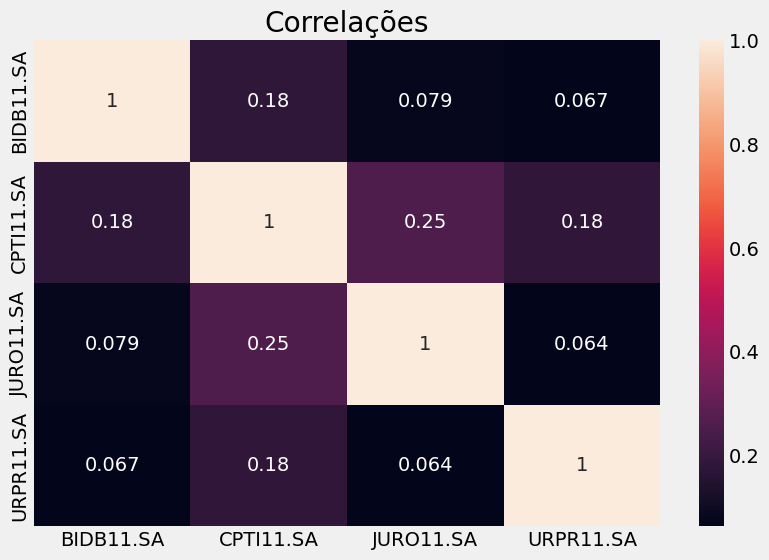

In [60]:
## correlações
plt.figure()
sns.heatmap(retornos.corr(), annot=True) #retornos é calculado no código anterior
plt.title('Correlações')

---------------------------------------------------------------
--- heuristica: alocação de maior índice de sharpe ------------
[('BIDB11.SA', 0.41298), ('CPTI11.SA', 0.36417), ('JURO11.SA', 0.22068), ('URPR11.SA', 0.00216)]
Retorno esperado       0.1448
Volatilidade           0.0602
Índice de Sharpe       2.398
---------------------------------------------------------------
--- heuristica: alocação de menor risco -----------------------
[('BIDB11.SA', 0.34716), ('CPTI11.SA', 0.29564), ('JURO11.SA', 0.22039), ('URPR11.SA', 0.13681)]
Retorno esperado       0.1279
Volatilidade           0.0573
Índice de Sharpe       2.226


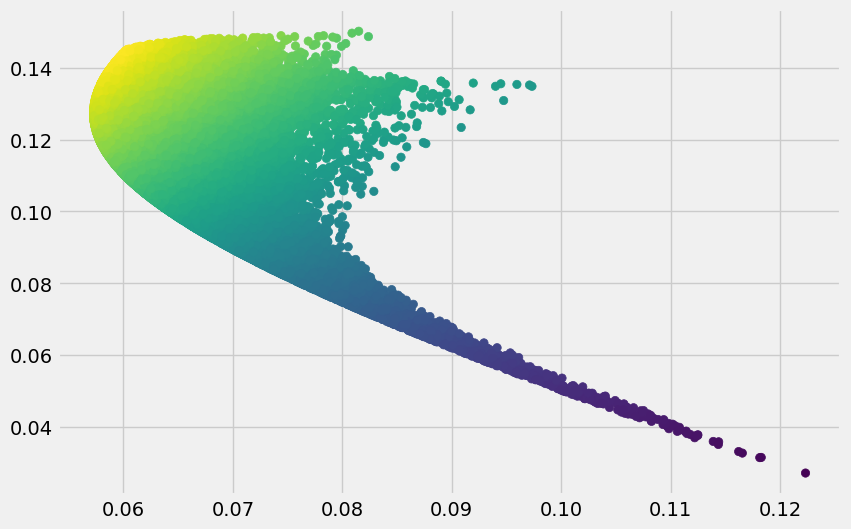

In [61]:
#########################################################################
### SIMULACAO Monte-Carlo
## heuristica otimização melhor indice sharpe e menor risco
pesos, medias, desvios = Monte_Carlo(retornos, len(acoes) , 100000)
sharpe  = (medias - taxa_livre_risco_ad)/desvios
print('---------------------------------------------------------------')
print('--- heuristica: alocação de maior índice de sharpe ------------')
#### indice do max sharpe na simulação
ind_max_s = sharpe.argmax()
print(list(zip(acoes,list(pesos[ind_max_s].round(5)))))
print('Retorno esperado      ' , round(medias[ind_max_s],4))
print('Volatilidade          ' , round(desvios[ind_max_s],4))
print('Índice de Sharpe      ' , round(sharpe[ind_max_s],3))
print('---------------------------------------------------------------')
print('--- heuristica: alocação de menor risco -----------------------')
#### indice de min volatilidade na simulação
ind_min_s = desvios.argmin()
print(list(zip(acoes,list(pesos[ind_min_s].round(5)))))
print('Retorno esperado      ' , round(medias[ind_min_s],4))
print('Volatilidade          ' , round(desvios[ind_min_s],4))
print('Índice de Sharpe      ' , round(sharpe[ind_min_s],3))
### gráfico
plt.figure(2)
plt.scatter(desvios,medias,c=sharpe)
#       plt.scatter(desvios[ind_max_s] , medias[ind_max_s] , c='red', marker='s', s=50)
#       plt.scatter(desvios[ind_min_s] , medias[ind_min_s] , c='blue', marker='s', s=50)

In [62]:
#########################################################################
##### OTIMIZACAO - max Sharpe
optimum_s=otimizacao_funcao(max_sharpe, retornos)
print('----------------------------------------------------------------')
print('--- otimização: distribuição dos pesos com IS ótimo ------------')
print(list(zip(acoes,list(optimum_s['x'].round(5)))))
medias_opt = np.sum(retornos.mean()*optimum_s['x'])*252
desvios_opt= np.sqrt(np.dot(optimum_s['x'].T,np.dot(retornos.cov()*252,optimum_s['x'])))
sharpe_opt = (medias_opt - taxa_livre_risco_ad)/desvios_opt
print('Retorno esperado ' , round(medias_opt,5))
print('Volatilidade     ' , round(desvios_opt,5))
print('Indice de Sharpe ' , round(sharpe_opt,5))
#####
##### OTIMIZACAO - min variancia
#####
optimum_v=otimizacao_funcao(min_volatilidade , retornos)
print('----------------------------------------------------------------')
print('---  otimização: distribuição com menor volatilidade -----------')
print(list(zip(acoes,list(optimum_v['x'].round(5)))))
medias_vol = np.sum(retornos.mean()*optimum_v['x'])*252
desvios_vol= np.sqrt(np.dot(optimum_v['x'].T,np.dot(retornos.cov()*252,optimum_v['x'])))
sharpe_vol = (medias_vol - taxa_livre_risco_ad)/desvios_vol
print('Retorno esperado ' , round(medias_vol,5))
print('Volatilidade     ' , round(desvios_vol,5))
print('Indice de Sharpe ' , round(sharpe_vol,5))
### gráfico
plt.figure(2)
#       plt.scatter(desvios_opt, medias_opt, c='blue', marker='*', s=190)  # estrela vermelho
#       plt.scatter(desvios_vol, medias_vol, c='blue', marker='*', s=190) # estrela azul

----------------------------------------------------------------
--- otimização: distribuição dos pesos com IS ótimo ------------
[('BIDB11.SA', 0.41767), ('CPTI11.SA', 0.35993), ('JURO11.SA', 0.2224), ('URPR11.SA', 0.0)]
Retorno esperado  0.14506
Volatilidade      0.06029
Indice de Sharpe  2.39926
----------------------------------------------------------------
---  otimização: distribuição com menor volatilidade -----------
[('BIDB11.SA', 0.35074), ('CPTI11.SA', 0.28518), ('JURO11.SA', 0.22211), ('URPR11.SA', 0.14197)]
Retorno esperado  0.12732
Volatilidade      0.05728
Indice de Sharpe  2.21558


<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

[0.03       0.20571906 0.13801507]
[ 0. -0.  0.]
[('BIDB11.SA', 0.106), ('CPTI11.SA', 0.001), ('JURO11.SA', 0.198), ('URPR11.SA', 0.696)]


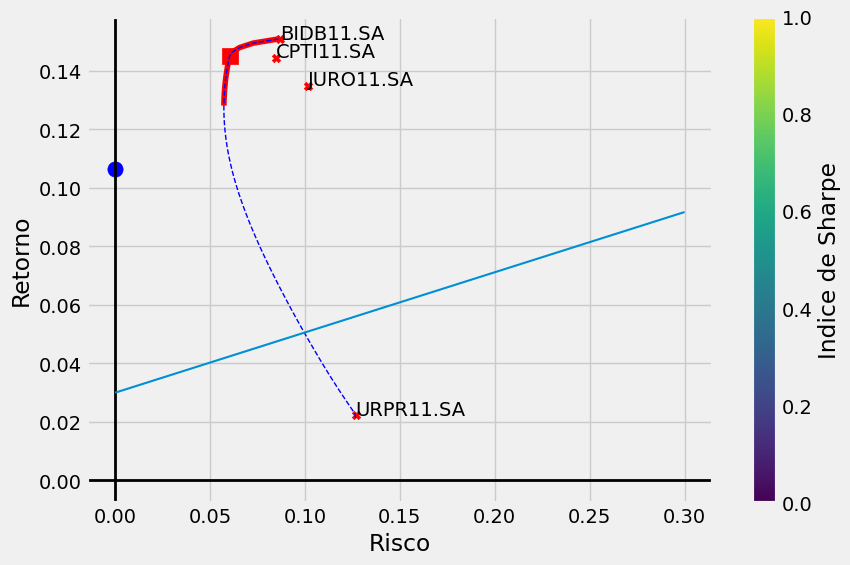

In [63]:
#########################################################################
#####  Fronteira
front_x , front_y = fronteira(retornos)
## Fronteira eficiente
min_index = np.argmin(front_x)
eretor = front_x[min_index:]
evolat = front_y[min_index:]
plt.figure(2)
plt.plot(eretor ,  evolat , 'r-'  , linewidth=4 )
plt.plot(front_x, front_y , 'b--' , linewidth=1 )
plt.scatter(desvios_opt, medias_opt, c='red', marker='s', s=120)
plt.scatter(0, selic/100 , c='blue', marker='o', s=120)

#########################################################################
### grafico final
plt.grid(True)
for t in acoes:
        tx = np.sqrt(retornos[t].var()*252)
        ty = retornos[t].mean()*252
        plt.figure(2)
        plt.scatter(tx,ty,c='red', marker='X')
        plt.text(tx,ty,str(t))
plt.xlabel('Risco')
plt.ylabel('Retorno')
plt.colorbar(label='Indice de Sharpe')
plt.axhline(0, color='k',  lw=2.0)
plt.axvline(0, color='k',  lw=2.0)

taxa_livre_risco_ad=0.03
#interpolação dos pontos da fronteira
tck  = sci.splrep(evolat, eretor)
# Via this numerical route we end up being able to define a
# continuously differentiable function f(x) for the efficient
# frontier and the respective first derivative function df(x) :
def f(x):
        ''' Efficient frontier function (splines approximation). '''
        return sci.splev(x, tck, der=0)
def df(x):
        ''' First derivative of efficient frontier function. '''
        return sci.splev(x, tck, der=1)
#What we are looking for is a function t(x) = a + b · x
#describing the line that passes through the riskless asset in
#risk-return space and that is tangent to the efficient
#frontier. All conditions that the function t(x) has to
#satisfy:
# t(x) = a + bx
# t(0) = r_f  <=> a=r_f
# t(x) = f(x) <=> f(x) = a + bx
# t'(x) = f'(x) <=> f'(x) = b
#Since we do not have a closed formula for the efficient
#frontier or the first derivative of it, we have to solve the
#system of equations in Equation 11-4 numerically. To this end,
#we define a Python function that returns the values of all
#three equations given the parameter set p = (a,b,x):
def eqs(p, rf=taxa_livre_risco_ad):
        eq1 = rf - p[0]
        eq2 = rf + p[1] * p[2] - f(p[2])
        eq3 = p[1] - df(p[2])
        return eq1, eq2, eq3
#The function fsolve from scipy.optimize is capable of solving
#such a system of equations. We provide an initial
#parameterization in addition to the function equations .  Note
#that success or failure of the optimization might depend on the
#initial parameterization, which therefore has to be chosen
#carefully
opt = scpopt.fsolve(eqs, [0.3, .1, .1])
#As desired, we have a = r f = 0.01
print(opt)
#array([ 0.01, 1.01498858,0.22580367])
#The three equations are also, as desired, zero:
print(np.round(eqs(opt), 6))
#array([ 0., -0., -0.])
plt.figure(2)
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, linewidth=1.5)
# capital market line
#        plt.plot(opt[2], f(opt[2]), 'rD', markersize=5.0)

#The portfolio weights of the optimal (tangent) portfolio are
#as follows. Only three of the five assets are in the mix:
cons = ({'type': 'eq', 'fun': lambda x: estatisticas_portifolio(x,retornos)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0.0,1) for x in range(len(acoes)))
res = scpopt.minimize(min_volatilidade,
                      len(acoes) * [1. / len(acoes),],
                      args = retornos,
                      method='SLSQP',
                      bounds=bnds,
                      constraints=cons)

# array([ 0.684,0.059,0.257, -0.,0.])
print(list(zip(acoes,list(res['x'].round(3)))))
plt.show()
